In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap
import re
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 60)

# 1. Motivation

* **What is your dataset?**

We will use the Building and Housing Register (BBR) which is a nationwide register with data on all buildings and dwellings in Denmark. Originaly the dataset had the size of 11 GB, however we will only focus on the greater area of Copenhagen. We will compine it with the dataset from Energistyrelsen called EMOData, which contains the energy rating of buildings in Denmark.

* **Why did you choose this/these particular dataset(s)?**

We will the Building and Housing Register (BBR) data because it have generel information about the buildings, such as the materials of the walls and the roof and the heating type the building is using. We compine it with the dataset from Energistyrelsen because we want to use Machine Learning calcification on the datasets, which can give an insight in the data

* **What was your goal for the end user's experience?** #TODO

This project can hopefully give the user (Danish government and municipalities) an overview of how sustainable their buildings are, compared to their function, materials or the general wealth of the area. This can help them make decisions toward reducing CO2 emissions with 70 procent in 2030[<sup>1</sup>](#fn1).


# Data cleaning

# 2. Basic stats

## 2.1 Data cleaning and preprocessing

### BBR

We will remove unnecessary text from columns in the BBR dataset, so it is easier to interpret what the value is. An example could be going from `https://inspire.ec.europa.eu/codelist/HeatingSystemValue/stove` to `stove`.

In [736]:
BBR = pd.read_csv("final_data.csv")

# Function for removing unnecessary text in column
def filter_text(data):
    return [" ".join(re.split('(?=[A-Z])',(x.split("/")[-1]))) for x in data]

# Removing unnecessary text in columns
BBR['buildingNature'] = filter_text(BBR['buildingNature'])
BBR['conditionOfConstruction'] = filter_text(BBR['conditionOfConstruction'])
BBR['currentUse'] = filter_text(BBR['currentUse'])
BBR['heatingSource'] = filter_text(BBR['heatingSource'])
BBR['heatingSystem'] = filter_text(BBR['heatingSystem'])
BBR['horizontalGeometryReference'] = filter_text(BBR['horizontalGeometryReference'])
BBR['materialOfRoof'] = filter_text(BBR['materialOfRoof'])
BBR['materialOfWall'] = filter_text(BBR['materialOfWall'])
BBR['officialAreaReference'] = filter_text(BBR['officialAreaReference'])
BBR['heightAboveGround_heightReference'] = filter_text(BBR['heightAboveGround_heightReference'])
BBR['heightAboveGround_lowReference'] = filter_text(BBR['heightAboveGround_lowReference'])
BBR['heightAboveGround_status'] = filter_text(BBR['heightAboveGround_status'])

In Greater Copenhagen are the zip code numbers between 1000 to 2999, however a municipality have many unique zip code within and the dataset are missing the municipality. We will therefore add it to the dataset.

In [737]:
# Removing rows which isn't in Greater Copenhagen
BBR = BBR[BBR['zip_code'] != 2680] #Solrød Strand
BBR = BBR[BBR['zip_code'] != 2690] #Karlslunde
BBR = BBR[BBR['zip_code'] != 2670] #Greve
BBR = BBR.reset_index(drop=True)

In [738]:
# Function for finding the municipality for the corresponding zip code
def get_municipality(data, dictionary):
    return [dictionary[data['zip_code'][x]] for x in range(len(data))]

# Making a dict with zip codes and their corresponding municipality
Kom = pd.read_excel('Kommuner_postnumre.xlsx')
KomDict = dict(zip(Kom.Postnummer, Kom.Kommune))

BBR['Kommune'] = get_municipality(BBR, KomDict)

### EMOData

In [739]:
EMO = pd.read_csv("Merged_data.csv")

In [740]:
# Removing rows with nan-values in the column HeatSupply
EMO = EMO[EMO['HeatSupply'].notna()]
EMO = EMO.reset_index(drop=True)

In [741]:
# Removing unnecessary text in columns
EMO['buildingNature'] = filter_text(EMO['buildingNature'])
EMO['conditionOfConstruction'] = filter_text(EMO['conditionOfConstruction'])
EMO['currentUse'] = filter_text(EMO['currentUse'])
EMO['heatingSource'] = filter_text(EMO['heatingSource'])
EMO['heatingSystem'] = filter_text(EMO['heatingSystem'])
EMO['horizontalGeometryReference'] = filter_text(EMO['horizontalGeometryReference'])
EMO['materialOfRoof'] = filter_text(EMO['materialOfRoof'])
EMO['materialOfWall'] = filter_text(EMO['materialOfWall'])
EMO['officialAreaReference'] = filter_text(EMO['officialAreaReference'])
EMO['heightAboveGround_heightReference'] = filter_text(EMO['heightAboveGround_heightReference'])
EMO['heightAboveGround_lowReference'] = filter_text(EMO['heightAboveGround_lowReference'])
EMO['heightAboveGround_status'] = filter_text(EMO['heightAboveGround_status'])
EMO['numberOfDwellings'] = EMO['numberOfDwellings'].replace(['other:unknown'],0)
EMO['numberOfDwellings'] = EMO['numberOfDwellings'].astype(int)
EMO['numberOfDwellings'] = EMO['numberOfDwellings'].replace([0],np.nan)
EMO['officialArea'] = EMO['officialArea'].replace(['other:unknown'],0)
EMO['officialArea'] = EMO['officialArea'].astype(int)
EMO['officialArea'] = EMO['officialArea'].replace([0],np.nan)
EMO['dateOfRenovation_dateOfEvent_anyPoint'] = EMO['dateOfRenovation_dateOfEvent_anyPoint'].replace(['other:unpopulated'],0)
EMO['dateOfRenovation_dateOfEvent_anyPoint'] = EMO['dateOfRenovation_dateOfEvent_anyPoint'].astype(int)
EMO['dateOfRenovation_dateOfEvent_anyPoint'] = EMO['dateOfRenovation_dateOfEvent_anyPoint'].replace([0],np.nan)

EMO["YearOfRenovation"] = " "

for i in range(len(EMO['YearOfConstruction'])):
    
    if len(EMO['YearOfConstruction'][i].split(',')) > 1:
        
        if len(set(EMO['YearOfConstruction'][i].split(','))) == 1:
            EMO['YearOfConstruction'][i] = EMO['YearOfConstruction'][i].split(',')[0]
            EMO["YearOfRenovation"][i] = 0
            
        elif len(set(EMO['YearOfConstruction'][i].split(','))) > 1:
            EMO['YearOfConstruction'][i] = EMO['YearOfConstruction'][i].split(',')[0]
            EMO["YearOfRenovation"][i] = EMO['YearOfConstruction'][i].split(',')[-1]
            
    else:
        EMO["YearOfRenovation"][i] = 0
            
        

In [742]:
# Remove all building which haven't been building in the years between 1500 to 2022
fjern = [9545]
for i in range(len(EMO['YearOfConstruction'])):

    if len(EMO['YearOfConstruction'][i]) != 4:
        fjern.append(i)
EMO = EMO.drop(EMO.index[fjern])
EMO['YearOfConstruction'] = EMO['YearOfConstruction'].astype(int)
EMO = EMO[EMO['YearOfConstruction'].between(1500, 2023)]

def drop_dup_b(data):
    data = data.reset_index(drop=True)
    idL = []
    AL = []
    for i in range(0, len(data)-1):
        if data['addressRepresentation'][i] not in AL:
            AL.append(data['addressRepresentation'][i])
            idL.append(data['id'][i])
            
        elif data['addressRepresentation'][i] in AL:
            continue
            
    return data[data['id'].isin(idL)]

EMO = drop_dup_b(EMO)

The dataset feature `EnergyLabelClassification` contains many different labels from A to G and these letters also have numbers to differ between them. We will remove the numbers so it is easier to group the different energy labels.

In [743]:
#Function for removing numbers in string
def remove_int(data):
    return [re.sub(r'[0-9]+', '', x) for x in data]

# Removing numbers from EnergyLabelClassification
EMO['EnergyLabelClassification'] = remove_int(EMO['EnergyLabelClassification'])

# Removing EnergyLabelClassification XX
EMO = EMO[EMO.EnergyLabelClassification != 'XX']

In [776]:
# Making year intervals for year of contruction and year of renovation
EMO['YearOfConstruction_Interval'] = ' '
EMO['YearOfRenovation_Interval'] = ' '
EMO = EMO.reset_index(drop=True)
for i in range(len(EMO)):
    
    if 1700 <= EMO['YearOfConstruction'][i] <= 1900:
        EMO['YearOfConstruction_Interval'][i] = '1700-1900'
        
    elif 1700.0 <= EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1900.0:
        EMO['YearOfRenovation_Interval'][i] = '1700-1900'
        
    elif 1900 < EMO['YearOfConstruction'][i] <= 1910:
        EMO['YearOfConstruction_Interval'][i] = '1901-1910'
        
    elif 1900.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1910.0:
        EMO['YearOfRenovation_Interval'][i] = '1901-1910'
        
    elif 1910 < EMO['YearOfConstruction'][i] <= 1920:
        EMO['YearOfConstruction_Interval'][i] = '1911-1920'
        
    elif 1910.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1920.0:
        EMO['YearOfRenovation_Interval'][i] = '1911-1920'

    elif 1920 < EMO['YearOfConstruction'][i] <= 1930:
        EMO['YearOfConstruction_Interval'][i] = '1921-1930'
        
    elif 1920.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1930.0:
        EMO['YearOfRenovation_Interval'][i] = '1921-1930'
        
    elif 1930 < EMO['YearOfConstruction'][i] <= 1940:
        EMO['YearOfConstruction_Interval'][i] = '1931-1940'
        
    elif 1930.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1940.0:
        EMO['YearOfRenovation_Interval'][i] = '1931-1940'
        
    elif 1940 < EMO['YearOfConstruction'][i] <= 1950:
        EMO['YearOfConstruction_Interval'][i] = '1941-1950'
        
    elif 1940.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1950.0:
        EMO['YearOfRenovation_Interval'][i] = '1941-1950'

    elif 1950 < EMO['YearOfConstruction'][i] <= 1960:
        EMO['YearOfConstruction_Interval'][i] = '1941-1950'
        
    elif 1950.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1960.0:
        EMO['YearOfRenovation_Interval'][i] = '1951-1960'
        
    elif 1960 < EMO['YearOfConstruction'][i] <= 1970:
        EMO['YearOfConstruction_Interval'][i] = '1961-1970'
        
    elif 1960.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1970.0:
        EMO['YearOfRenovation_Interval'][i] = '1961-1970'
        
    elif 1970 < EMO['YearOfConstruction'][i] <= 1980:
        EMO['YearOfConstruction_Interval'][i] = '1971-1980'
        
    elif 1970.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1980.0:
        EMO['YearOfRenovation_Interval'][i] = '1971-1980'
        
    elif 1980 < EMO['YearOfConstruction'][i] <= 1990:
        EMO['YearOfConstruction_Interval'][i] = '1981-1990'
        
    elif 1980.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1990.0:
        EMO['YearOfRenovation_Interval'][i] = '1981-1990'
        
    elif 1990 < EMO['YearOfConstruction'][i] <= 2000:
        EMO['YearOfConstruction_Interval'][i] = '1991-2000'
        
    elif 1990.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 2000.0:
        EMO['YearOfRenovation_Interval'][i] = '1991-2000'
        
    elif 2000 < EMO['YearOfConstruction'][i] <= 2010:
        EMO['YearOfConstruction_Interval'][i] = '2001-2010'
        
    elif 2000.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 2010.0:
        EMO['YearOfRenovation_Interval'][i] = '2001-2010'
        
    elif 2010 < EMO['YearOfConstruction'][i] <= 2023:
        EMO['YearOfConstruction_Interval'][i] = '2011-'
        
    elif 2010.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 2023.0:
        EMO['YearOfRenovation_Interval'][i] = '2011-'

EMO['YearOfRenovation_Interval'] = EMO['YearOfRenovation_Interval'].replace(' ',np.nan)

C:\Users\hcmik\AppData\Local\Temp/ipykernel_10196/373980039.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EMO['YearOfConstruction_Interval'][i] = '1931-1940'
C:\Users\hcmik\AppData\Local\Temp/ipykernel_10196/373980039.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EMO['YearOfConstruction_Interval'][i] = '1901-1910'
C:\Users\hcmik\AppData\Local\Temp/ipykernel_10196/373980039.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

### Income data

In [777]:
Income = pd.read_excel('Kommune_indkomst.xlsx')
# Making the column Kommune from the Income dataset the same format as the Kommune column in the EMO dataset
Income['Kommune'] = Income['Kommune'].astype(str) + ' Kommune'
Income['Kommune'][47] = 'Københavns Kommune'

# Function for removing letters and punctations from string
def remove_LP(data):
    return [re.sub(r'[kr.\s]', '', str(x)) for x in data]

# Removing letters and punctations
Income['Gennemsnitsindkomst'] = remove_LP(Income['Gennemsnitsindkomst'])
Income['Kvadratmeterpris'] = remove_LP(Income['Kvadratmeterpris'])
Income['Gennemsnitslig husleje'] = remove_LP(Income['Gennemsnitslig husleje'])
#Income['Kommuneskat'] = remove_LP(Income['Kommuneskat'])
Income['Gæld'] = remove_LP(Income['Gæld'])
Income['Pensionsopsparing'] = remove_LP(Income['Pensionsopsparing'])

# Converting columns from string to integer
Income['Gennemsnitsindkomst'] = Income['Gennemsnitsindkomst'].astype(int)
Income['Kvadratmeterpris'] = Income['Kvadratmeterpris'].astype(int)
Income['Gennemsnitslig husleje'] = Income['Gennemsnitslig husleje'].replace(['nan'],0)
Income['Gennemsnitslig husleje'] = Income['Gennemsnitslig husleje'].astype(int)
Income['Kommuneskat'] = Income['Kommuneskat'].replace(['nan'],0)
Income['Kommuneskat'] = Income['Kommuneskat'].astype(float)
Income['Gæld'] = Income['Gæld'].replace(['nan'],0)
Income['Gæld'] = Income['Gæld'].astype(int)
Income['Pensionsopsparing'] = Income['Pensionsopsparing'].replace(['nan'],0)
Income['Pensionsopsparing'] = Income['Pensionsopsparing'].astype(int)

C:\Users\hcmik\AppData\Local\Temp/ipykernel_10196/2154302617.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Income['Kommune'][47] = 'Københavns Kommune'


In [778]:
final_data = pd.merge(EMO, Income, on="Kommune")

final_data['Kommune'] = final_data['Kommune'].apply(lambda x: x.split(' ')[0])
final_data['Kommune'] = final_data['Kommune'].replace(['Københavns'],'København')
final_data = final_data.reset_index(drop=True)

In [779]:
# Removing unnecessary columns
final_data = final_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'geom', 'buildingNature', 'conditionOfConstruction',
                         'connectionToGas', 'dateOfConstruction_dateOfEvent_begin', 'dateOfConstruction_dateOfEvent_end'
                        , 'dateOfDemolition', 'dateOfRenovation_dateOfEvent_begin', 'dateOfRenovation_dateOfEvent_end'
                        ,'dateOfConstruction_dateOfEvent_anyPoint', 'document', 'elevation', 'endLifeSpanVersion'
                        ,'energyPerformance', 'externalReference_reference1', 'externalReference_reference2'
                        ,'externalReference_system1', 'externalReference_system2', 'externalReference_systemName1'
                        ,'externalReference_systemName2', 'floorDescription_floorRange','floorDescription'
                        ,'geometry_horizontalAccuracy_uom','geometry_verticalAccuracy', 'geometry_verticalAccuracy_uom'
                        ,'heatingSource', 'heatingSystem', 'heightAboveGround_value', 'heightAboveGround_heightReference'
                        ,'heightAboveGround_lowReference', 'heightAboveGround_status', 'heightBelowGround', 'heightParameter'
                        ,'horizontalGeometryReference', 'inspireId_localId', 'inspireId_versionId', 'officialAreaReference'
                        ,'zip_code', 'lat', 'lon', 'Name', 'id_address', 'BBRUseCode', 'BuildingNumber', 'CityName', 'DEMOLink'
                        ,'EnergyLabelSerialIdentifier', 'EnergyLabelTypeBasedOn','EnergyLabelTypeUsage', 'EntityIdentifier'
                        ,'HasPdf', 'HasXML', 'HouseNumber', 'IsHidden', 'IsMixedUsage', 'LabelStatusCode', 'MunicipalityNumber'
                        ,'PropertyNumber', 'SchemaVersion', 'StreetName', 'SubmitterCompanyIdentifier', 'SubmitterCompanyName'
                        ,'SubmitterConsultantName', 'ZipCode', 'Region', 'Antal til salg pr. indbygger', 'Grundskyld'
                        ,'Bruttoledige'])

In [780]:
final_data.to_pickle('final_final_data.pkl')

## 2.2 Exploratory Data Analysis

In [613]:
final_data.shape

(121428, 28)

The cleaned data have the shape of (123060, 28). There are 28 features, all these features will not be used in Part 3 Data Analysis, however we will remove and argument why we remove them in Part 3 Data Analysis.

We'll briefly explain the most attributes in the dataset as this is essential to understand the following analysis

* **addressRepresentation** (string): The adresse of the building
* **Kommune** (string): The municipality the building is in
* **Wgs84Latitude** (float): The latitude of the building
* **Wgs84Longitude** (float): The longitude of the building
* **EnergyLabelClassification** (string): The energy label of the building
* **HeatSupply** (string): The type of heat supply the building use
* **YearOfConstruction** (integer): The year the building have been constructed
* **dateOfRenovation_dateOfEvent_anyPoint** (integer): The year the building have been renovated
* **materialOfRoof** (string): The material used for the roof of the building
* **materialOfWall** (string): The material used for the walls of the building

In [546]:
final_data.describe()

,id,dateOfRenovation_dateOfEvent_anyPoint,numberOfDwellings,numberOfFloorsAboveGround,numberOfFloorsBelowGround,officialArea,Wgs84Latitude,Wgs84Longitude,YearOfConstruction,Gennemsnitsindkomst,Kvadratmeterpris,Gennemsnitslig husleje,Kommuneskat,Gæld,Pensionsopsparing
count,1.230600e+05,31976.000000,91884.000000,123060.000000,123060.000000,114358.000000,123060.000000,123060.000000,123060.000000,123060.000000,123060.000000,123060.000000,123060.000000,1.230600e+05,1.230600e+05
mean,2.858245e+06,1980.957187,5.512668,1.605826,0.506379,283.267257,55.695387,12.485592,1951.053210,352103.476012,37839.876914,892.178742,0.367431,8.216094e+05,8.982692e+05
std,1.454918e+06,21.727339,16.549740,1.460635,0.519099,822.267940,0.073673,0.140627,39.264644,88418.113588,8851.289525,75.094340,0.009701,4.518983e+05,3.469062e+05
min,3.700000e+01,1763.000000,1.000000,0.000000,0.000000,1.000000,55.562030,11.417312,1558.000000,273059.000000,22642.000000,694.000000,0.352100,4.957280e+05,5.291580e+05
25%,1.618335e+06,1969.000000,1.000000,1.000000,0.000000,85.000000,55.651596,12.442706,1930.000000,311523.000000,30356.000000,853.000000,0.358600,5.166540e+05,5.291580e+05
50%,2.877794e+06,1979.000000,1.000000,1.000000,0.000000,124.000000,55.685358,12.498371,1954.000000,311523.000000,37466.000000,907.000000,0.367500,6.574330e+05,8.406970e+05
75%,4.116968e+06,1997.000000,1.000000,2.000000,1.000000,202.000000,55.733596,12.567845,1972.000000,331848.000000,45189.000000,935.000000,0.372500,8.445950e+05,1.003660e+06
max,5.307873e+06,2021.000000,748.000000,30.000000,6.000000,57855.000000,56.191292,12.680430,2022.000000,579957.000000,49870.000000,1062.000000,0.386000,1.996452e+06,1.772259e+06


Initially, we look at the municipalities to see which is most represented in our dataset.

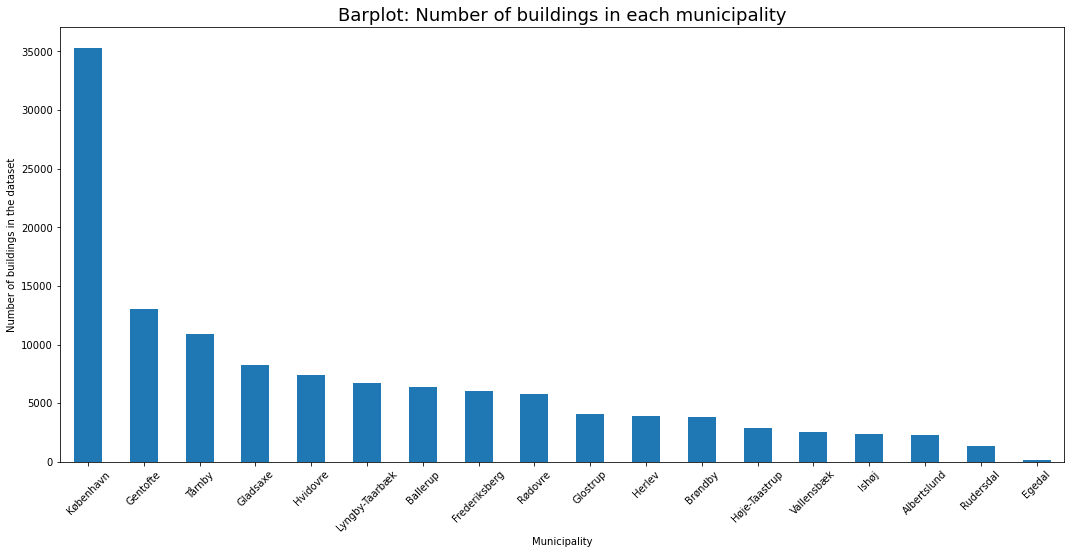

In [567]:
P_of_house = final_data.groupby('Kommune').count()['id']

fig, ax = plt.subplots(figsize=(18,8))
(P_of_house.sort_values(ascending = False)).plot(kind = 'bar', ax = ax, rot = 45)
ax.set_xlabel('Municipality')
ax.set_ylabel('Number of buildings in the dataset')
ax.set_title('Barplot: Number of buildings in each municipality', size = 18)
plt.show()

The municipality with most buildings is "Københavns Kommune" which makes sense because it have the biggest area, most people and is the capital. On the other hand we have "Egedal Kommune" which only have around 150 buildings, which have been energy labeled.

We will also take a quick look at how the energy labels are distributed in our dataset. To see how the situation are with the buildings in Greater Copenhagen

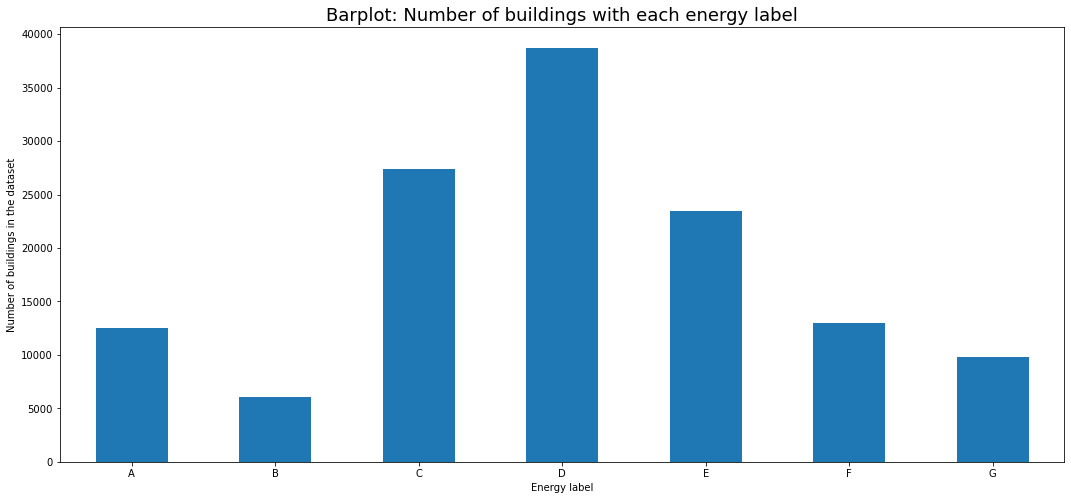

In [242]:
EL = final_data.groupby('EnergyLabelClassification').count()['id']

fig, ax = plt.subplots(figsize=(18,8))
EL.plot(kind = 'bar', ax = ax, rot = 0)
ax.set_xlabel('Energy label')
ax.set_ylabel('Number of buildings in the dataset')
ax.set_title('Barplot: Number of buildings with each energy label', size = 18)
plt.show()

It appears that the energy label which most buildings are classified as is D, which also is the middel ground on the scala. We can see that more buildings are classified as A and C than E and G, which is a good sign for the energy usage in Greater Copenhagen, however more buildings are classified as F than B. 

# 3. Data Analysis

In [661]:
# Copy dataframe
ML_data = final_data.copy()

# Making dummy variables
#ML_data = pd.get_dummies(data=ML_data, columns=['race', 'sex'])

In [662]:
def drop_dup_b(data)
    idL = []
    AL = []
    for i in range(len(data)):
        if data['addressRepresentation'][i] in AL:
            continue
        elif data['addressRepresentation'][i] not in AL:
            AL.append(data['addressRepresentation'][i])
            idL.append(data['id'][i])
    return data.iloc[idL]

In [635]:
ML_data[ML_data['id'] == 250942]

,id,addressRepresentation,beginLifeSpanVersion,connectionToSewage,connectionToWater,currentUse,dateOfRenovation_dateOfEvent_anyPoint,materialOfRoof,materialOfWall,numberOfDwellings,numberOfFloorsAboveGround,numberOfFloorsBelowGround,officialArea,Kommune,EnergyLabelClassification,HeatSupply,LabelStatus,ValidFrom,ValidTo,Wgs84Latitude,Wgs84Longitude,YearOfConstruction,Gennemsnitsindkomst,Kvadratmeterpris,Gennemsnitslig husleje,Kommuneskat,Gæld,Pensionsopsparing
2412,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-08-29,2028-08-29,55.705462,12.433301,2018,308437,33481,891,0.3857,657433,820570
2413,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-08-29,2028-08-29,55.705290,12.433031,2018,308437,33481,891,0.3857,657433,820570
2414,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-08-29,2028-08-29,55.705324,12.433751,2018,308437,33481,891,0.3857,657433,820570
2415,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-10-03,2028-10-03,55.705829,12.432410,2018,308437,33481,891,0.3857,657433,820570
2416,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-10-03,2028-10-03,55.705652,12.432617,2018,308437,33481,891,0.3857,657433,820570
2417,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-10-03,2028-10-03,55.705749,12.433645,2018,308437,33481,891,0.3857,657433,820570
2418,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-10-03,2028-10-03,55.705252,12.433426,2018,308437,33481,891,0.3857,657433,820570
2419,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-11-19,2028-11-19,55.705768,12.433296,2018,308437,33481,891,0.3857,657433,820570
2420,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-11-19,2028-11-19,55.705990,12.432440,2018,308437,33481,891,0.3857,657433,820570
2421,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-11-19,2028-11-19,55.705945,12.433073,2018,308437,33481,891,0.3857,657433,820570


# 4. Genre

* **Which genre of data story did you use?**


* **Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?**


* **Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?**

# 5. Visualizations

# 6. Discussion

# Basic plots

**Bygningstyper:**

In [27]:
filter_text(df.heatingSystem.unique())

['stove',
 'central Heating',
 'district Heating',
 'electric Raditors',
 'heat Pump',
 'none',
 'other:unpopulated',
 'portable Gas Heating']

In [9]:
filter_text(df.currentUse.unique())

['residential',
 'individual Residence',
 'collective Residence',
 'residence For Communities',
 'public Services',
 'commerce And Services',
 'trade',
 'agriculture',
 'industrial',
 'other:unpopulated',
 'two Dwellings',
 'office',
 ' Unknown']

In [128]:
types_build= filter_text(BBR.currentUse.unique())
values_build=BBR.currentUse.value_counts()

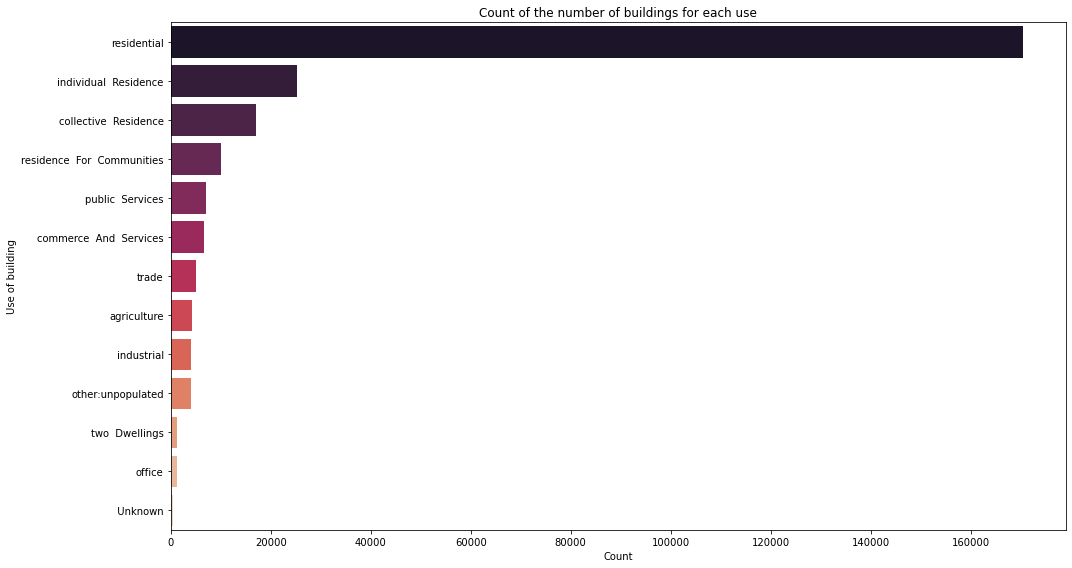

In [130]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(y=types_build, x=values_build,palette="rocket",orient="h");
ax.set_title("Count of the number of buildings for each use")
ax.set_xlabel("Count")
ax.set_ylabel("Use of building")
plt.tight_layout()
plt.savefig('Building_types.png',facecolor='w')

**Heating systems:**

In [12]:
df.heatingSystem.value_counts()

https://inspire.ec.europa.eu/codelist/HeatingSystemValue/centralHeating        111201
https://inspire.ec.europa.eu/codelist/HeatingSystemValue/districtHeating        97978
other:unpopulated                                                               22260
https://inspire.ec.europa.eu/codelist/HeatingSystemValue/electricRaditors       18179
https://inspire.ec.europa.eu/codelist/HeatingSystemValue/none                   14928
https://inspire.ec.europa.eu/codelist/HeatingSystemValue/heatPump               10011
https://inspire.ec.europa.eu/codelist/HeatingSystemValue/stove                   5083
https://inspire.ec.europa.eu/codelist/HeatingSystemValue/portableGasHeating       228
Name: heatingSystem, dtype: int64

In [13]:
types_mat= filter_text(df.materialOfRoof.unique())
values_mat=df.materialOfRoof.value_counts()

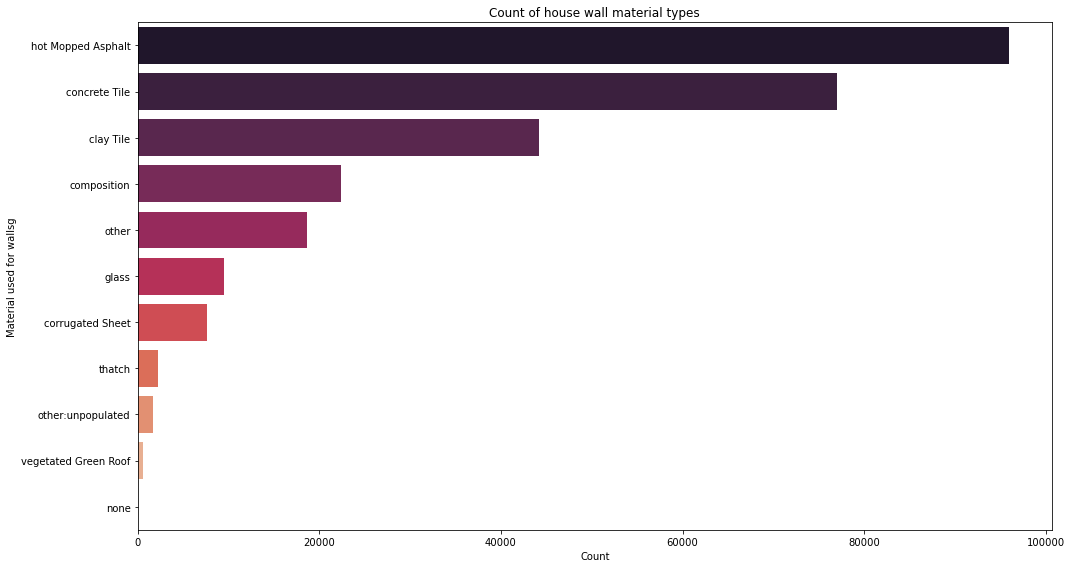

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(y=types_mat, x=values_mat,palette="rocket",orient="h");
ax.set_title("Count of house wall material types")
ax.set_xlabel("Count")
ax.set_ylabel("Material used for wallsg")
plt.tight_layout()
plt.savefig('Mat_types.png',facecolor='w')

In [15]:
df.materialOfWall.value_counts()

https://inspire.ec.europa.eu/codelist/MaterialOfFacadeValue/masonry      202611
https://inspire.ec.europa.eu/codelist/MaterialOfFacadeValue/wood          26926
other:unpopulated                                                         18679
https://inspire.ec.europa.eu/codelist/MaterialOfFacadeValue/concrete      13610
https://inspire.ec.europa.eu/codelist/MaterialOfFacadeValue/other          7677
https://inspire.ec.europa.eu/codelist/MaterialOfFacadeValue/composite      5823
https://inspire.ec.europa.eu/codelist/MaterialOfFacadeValue/glass          2610
https://inspire.ec.europa.eu/codelist/MaterialOfFacadeValue/adobe          1736
https://inspire.ec.europa.eu/codelist/MaterialOfFacadeValue/none            196
Name: materialOfWall, dtype: int64

# 8. References

[1]<span id="fn1"> https://ens.dk/en/our-responsibilities/energy-climate-politics/danish-climate-policies</span>